<div class="alert alert-block alert-info"><b></b>
<h1><center> <font color='black'> Homework 06  </font></center></h1>
<h2><center> <font color='black'> Knowledge graphs &  Fairness and Explainability </font></center></h2>
<h2><center> <font color='black'> Due date : 24 May 23:59 </font></center></h2>    
<h2><center> <font color='black'> BDA - University of Tartu - Spring 2020</font></center></h3>
</div>

# Homework Instructions

- Insert your team member names and student IDs in the field "Team mates" below. If you are not working in a team please insert only your name, surname and student ID 

- The accepted submission formats are Colab links or .ipynb files. If you are submitting Colab links please make sure that the privacy settings for the file is public so we can access your code. 

- The submission will automatically close at 12:00 am, so please make sure you have enough time to submit the homework. 

- Only one of the teammates should submit the homework. We will grade and give points to both of you! 

- You do not necessarily need to work on Colab. Especially as the size and the complexity of datasets will increase through the course, you can install jupyter notebooks locally and work from there.

- If you do not understand what a question is asking for, please ask in Moodle. 

**<h2><font color='red'>Team mates:</font></h2>**


<font color='red'>Name Surname: XXXXX</font>&emsp;   <font color='red'>Student ID: YYYY</font>


<font color='red'>Name Surname: XXXXX</font>&emsp;   <font color='red'>Student ID: YYYY</font>

# 1. Knowledge graphs (7 points)

## 1.1 Insurance fraud (2.5 points)

In this exercise you will try to depict car insurance fraudsters using knowledge graphs. Firstly, go through this [page](http://www.ibc.ca/on/auto/insurance-crime/staged-collisions) to learn more about the staged collisions. You can use additional sources if you want to get a more detailed information.

Load the datasets people.csv and accidents.csv. This is synthetic data and none of the records are related to actual events or people. The file people.csv contains information about 8 people who involved in four different accidents. The file accidents.csv contains data related to this four accidents.
The fields included are:

**Accident_ID:** Self-descriptive

**Location:** The location where the accident happened

**CarID_1:** The ID of the first car involved in the accident

**CarID_2:** The ID of the second car involved in the accident

**DriverID_1:** The ID of the user who was driving the car in CarID_1

**DriverID_2:** The ID of the user who was driving the car in CarID_2

**Take a look at the data in both dataframes. At least 3 out of 8 people are suspected to be fraudsters. Can you tell just by looking at the dataframes who might they be ?** (This is just a warm up for the exercise. No grades will be given for your answer. However we would be really interested to know if somebody has excellent observation skills)

In [1]:
%%capture
# !pip install ampligraph

import numpy as np
import pandas as pd
import ampligraph

import re
import bs4
import requests
import spacy
from spacy import displacy
import en_core_web_sm
nlp = en_core_web_sm.load()
# nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

ampligraph.__version__

In [2]:
import pandas as pd

people = pd.read_csv('people.csv')
accidents = pd.read_csv('accidents.csv')

print(people)
print(accidents)

   User_ID First Name Last Name  Age           Address  Accident_ID     ROLE
0        1    Chester    Murphy   25  Narva 108, Tartu            1   Driver
1        2     Walter    Turner   26   Tilgi 49, Tartu            2   Driver
2        3      Daryl    Fowler   25    Piik 67, Tartu            1   Driver
3        4        Ted    Nelson   45   Herne 20, Tartu            3   Driver
4        5     Olivia  Crawford   38  Kalevi 25, Tartu            2   Driver
5        1    Chester    Murphy   25  Narva 108, Tartu            2  Witness
6        6        Amy    Miller   27   Riia 408, Tartu            3   Driver
7        7        Tes     Smith   25  Narva 108, Tartu            4   Driver
8        8       Josh     Blake   36  Parnu 37, Tallin            4   Driver
9        3      Daryl    Fowler   25    Piik 67, Tartu            4  Witness
   Accident_ID Location  CarID_1  CarID_2  DriverID_1  DriverID_2
0            1    Tartu     1000     1001           1           3
1            2   Tall

<font color='red'> **Answer:** </font>
    
3 suscpected people as fraudsters:
- user_id 1
- user_id 3
- user_id 4
- user_id 7

**1.1.1 Knowledge graphs might help to recognize the fraudsters. In order to build knowledge graphs you have first to build the triples: source --> target --> edge. Store these triples in a new dataframe. The dataframe should cover all the relations in the table below:  (1.5 points)**

|      Source      |    Target   |     Edge    |
|:----------------:|:-----------:|:-----------:|
| User_ID(or Name) |    Car_ID   |    Drives   |
| User_ID(or Name) | Accident_ID |   Witness   |
|      Car_ID      | Accident_ID | Involved in |
|    Accident_ID   |   Location  | Happened in |
| User_ID(or Name) | Address     | Lives in    |

In [4]:
# people
df1 = people.drop(columns=['Age', 'First Name', 'Last Name'])
# df1['User_ID_Name'] = people['User_ID'].astype(str) + "_" + people['First Name'] + people['Last Name']
df1['FullName'] = people['First Name'] + people['Last Name']
df1 = df1.reindex(columns=['User_ID', 'FullName', 'Address', 'Accident_ID', 'ROLE'])
df1

,User_ID,FullName,Address,Accident_ID,ROLE
0,1,ChesterMurphy,"Narva 108, Tartu",1,Driver
1,2,WalterTurner,"Tilgi 49, Tartu",2,Driver
2,3,DarylFowler,"Piik 67, Tartu",1,Driver
3,4,TedNelson,"Herne 20, Tartu",3,Driver
4,5,OliviaCrawford,"Kalevi 25, Tartu",2,Driver
5,1,ChesterMurphy,"Narva 108, Tartu",2,Witness
6,6,AmyMiller,"Riia 408, Tartu",3,Driver
7,7,TesSmith,"Narva 108, Tartu",4,Driver
8,8,JoshBlake,"Parnu 37, Tallin",4,Driver
9,3,DarylFowler,"Piik 67, Tartu",4,Witness


In [5]:
df2 = accidents
df2

,Accident_ID,Location,CarID_1,CarID_2,DriverID_1,DriverID_2
0,1,Tartu,1000,1001,1,3
1,2,Tallin,1002,1003,2,5
2,3,Tartu,1004,1005,4,6
3,4,Tallin,1006,1007,7,8


In [6]:
# row1
triples = [('ChesterMurphy', '1000', 'Drives'),
            ('WalterTurner', '1001', 'Drives'),
            ('DarylFowler', '1002', 'Drives'),
            ('TedNelson', '1003', 'Drives'),
            ('OliviaCrawford', '1004', 'Drives'),
            ('AmyMiller', '1005', 'Drives'),
            ('TesSmith', '1006', 'Drives'),
            ('JoshBlake', '1007', 'Drives'),
          ]

In [7]:
# row2
triples.extend([('ChesterMurphy', '2', 'Witness'), 
                ('DarylFowler', '4', 'Witness')])

In [8]:
# row3
triples.extend([('1000', '1', 'Involved in'), 
                ('1001', '1', 'Involved in'), 
                ('1002', '2', 'Involved in'), 
                ('1003', '2', 'Involved in'), 
                ('1004', '3', 'Involved in'), 
                ('1005', '3', 'Involved in'), 
                ('1006', '4', 'Involved in'), 
                ('1007', '4', 'Involved in')])

In [9]:
# row4
triples.extend([('1', 'Tartu', 'Happened In'),
                ('2', 'Tallin', 'Happened In'),
                ('3', 'Tartu', 'Happened In'),
                ('4', 'Tallin', 'Happened In')])

In [10]:
# row5
triples.extend([('ChesterMurphy', 'Narva 108, Tartu', 'Lives In'),
                ('WalterTurner', 'Tilgi 49, Tartu', 'Lives In'),
                ('DarylFowler', 'Piik 67, Tartu', 'Lives In'),
                ('TedNelson', 'Herne 20, Tartu', 'Lives In'),
                ('OliviaCrawford', 'Kalevi 25, Tartu', 'Lives In'),
                ('AmyMiller', 'Riia 408, Tartu', 'Lives In'),
                ('TesSmith', 'Narva 108, Tartu', 'Lives In'),
                ('JoshBlake', 'Parnu 37, Tallin', 'Lives In')])

In [11]:
triples_df = pd.DataFrame(triples, columns=["source", "target", "edge"])
triples_df

,source,target,edge
0,ChesterMurphy,1000,Drives
1,WalterTurner,1001,Drives
2,DarylFowler,1002,Drives
3,TedNelson,1003,Drives
4,OliviaCrawford,1004,Drives
5,AmyMiller,1005,Drives
6,TesSmith,1006,Drives
7,JoshBlake,1007,Drives
8,ChesterMurphy,2,Witness
9,DarylFowler,4,Witness


**1.1.2 Use the dataframe which contains your triples to build a knowledge graph. You can use a paper drawing or any other drawing software. Hint: Try to keep an hierarchy while you draw i.e the accidents at the top at same level, the cars one level below etc. By doing so your graph will be more clear and you can easily get some clues. Insert the picture of your graph in the cell below.** <font color='red'> **Do not forget to send it in your submission as well** **(0.5 points)**

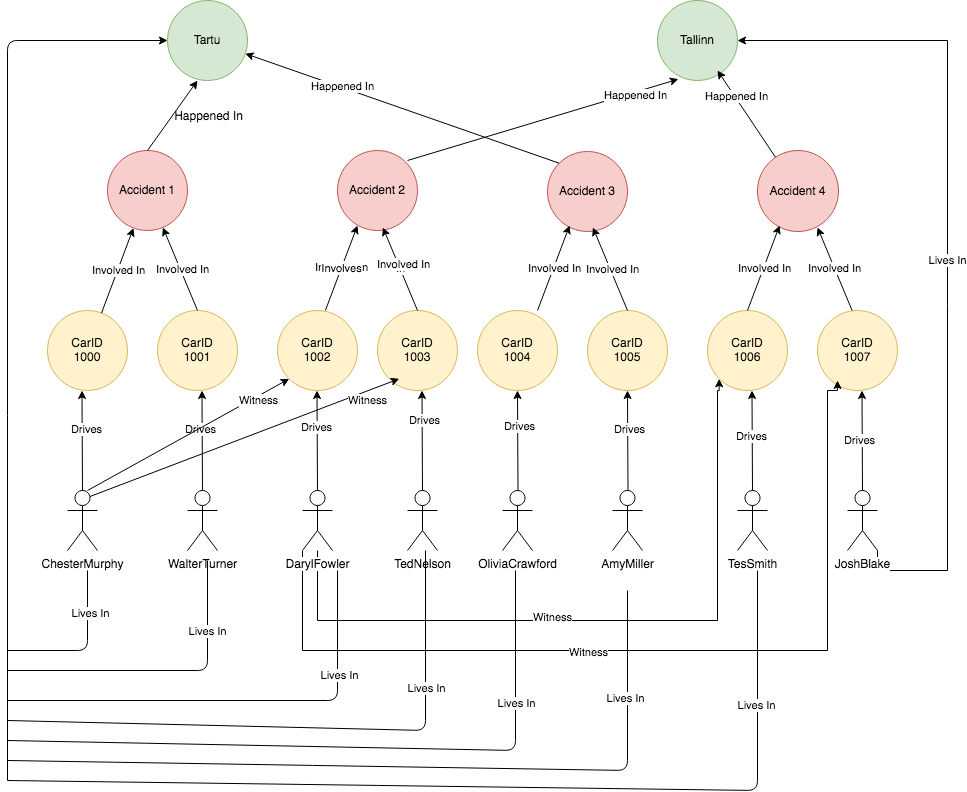

In [43]:
# Reference: https://neo4j.com/blog/insurance-fraud-detection-graph-database/

# Created using draw.io 

from IPython.display import Image
Image(filename="BDA2020_HW6_task1.1.2.png")

<!-- ![BDA2020_HW6_task1.1.2](BDA2020_HW6_task1.1.2.png "Insurance Fraud") -->

**1.1.3 Mention at least the names of 3 people that you think are commiting insurance fraud by looking at the knowledge graph. Describe the factors why did you choose those 3. The description should include at least 3 key points. Please elaborate as much as possible. (0.5 points)**

<font color='red'> **Answer:** </font>

Names at least 3 people:
- Chester Murphy (UserID 1)
- Daryl Fowler (UserID 3)
- Ted Nelson (UserID 4)
- Tes Smith (UserID 7)
<br>

Key factors:
- People who live in Tartu, but involved in the accident in Tallinn
- People who live in Tartu, but witnessed in the accident in Tallinn
- The accident happened in Tallinn, but involved two car drivers from Tartu (Accident 2)

## 1.2 Knowledge graph for clustering and classification (4.5 points)

In this exercise you are going to use the dataset from [kaggle](https://www.kaggle.com/jaykay12/odi-cricket-matches-19712017#ContinousDataset.csv) that contains all the ODI Cricket Matches in the interval 1971-2017. Cricket is a popular game  played in South Asian countries and Australia,
which was originally introduced by British colonization. If you would like more information, [Lagaan](https://www.youtube.com/watch?v=oSIGQ0YkFxs) is an intersting Oscar candidate movie that explains the relation between colonial taxes and popularity of cricket.

In this dataset the field "Ground" refers to the location where the match was held. 

**1.2.1 Load the dataset cricket_data.csv. Create the entities match_id, ground_id,country_id,home_team_id,away_team_id and neutral that are going to be part of our knowledge graph. (0.5 points)**

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('cricket_data.csv')
df.head()

,ground,date,winner,host_country,home_team,away_team,neutral
0,Melbourne,"Jan 5, 1971",Australia,Australia,Australia,England,False
1,Manchester,"Aug 24, 1972",England,England,England,Australia,False
2,Lord's,"Aug 26, 1972",Australia,England,England,Australia,False
3,Birmingham,"Aug 28, 1972",England,England,England,Australia,False
4,Christchurch,"Feb 11, 1973",New Zealand,New Zealand,New Zealand,Pakistan,False


In [2]:
df.isna().sum()

ground          0
date            0
winner          0
host_country    0
home_team       0
away_team       0
neutral         0
dtype: int64

In [3]:
# Entities naming
df["match_id"] = df.index.values.astype(str)
df["match_id"] =  "Match" + df.match_id
df["ground_id"] = "Ground" + df.ground.str.title().str.replace(" ", "")
df["country_id"] = "Country" + df.host_country.str.title().str.replace(" ", "")
df["home_team_id"] = "Team" + df.home_team.str.title().str.replace(" ", "")
df["away_team_id"] = "Team" + df.away_team.str.title().str.replace(" ", "")
df["neutral"] = df.neutral.astype(str)

In [4]:
df.head()

,ground,date,winner,host_country,home_team,away_team,neutral,match_id,ground_id,country_id,home_team_id,away_team_id
0,Melbourne,"Jan 5, 1971",Australia,Australia,Australia,England,False,Match0,GroundMelbourne,CountryAustralia,TeamAustralia,TeamEngland
1,Manchester,"Aug 24, 1972",England,England,England,Australia,False,Match1,GroundManchester,CountryEngland,TeamEngland,TeamAustralia
2,Lord's,"Aug 26, 1972",Australia,England,England,Australia,False,Match2,GroundLord'S,CountryEngland,TeamEngland,TeamAustralia
3,Birmingham,"Aug 28, 1972",England,England,England,Australia,False,Match3,GroundBirmingham,CountryEngland,TeamEngland,TeamAustralia
4,Christchurch,"Feb 11, 1973",New Zealand,New Zealand,New Zealand,Pakistan,False,Match4,GroundChristchurch,CountryNewZealand,TeamNewZealand,TeamPakistan


**1.2.2 Select manually 80%  as train set of the data and create the triples ['subject', 'predicate', 'object'] using the entities from 1.2.1. (1 points)** Hint: If there are some errors generated while building the triples check if match_id was formed correctly in 1.2.1

In [5]:
num_train = int(np.round(0.8 * len(df), 0)) # 80% of dataset
num_train

5891

In [6]:
df["train"] = df.index < num_train

In [7]:
df["train"].value_counts()

True     5891
False    1473
Name: train, dtype: int64

In [8]:
triples = []
for _, row in df[df["train"]].iterrows():
    # Home and away information
    home_team = (row["home_team_id"], "isHomeTeamIn", row["match_id"])
    away_team = (row["away_team_id"], "isAwayTeamIn", row["match_id"])
    
    # Match results
    if row["winner"] == row["home_team"]:
        score_home = (row["home_team_id"], "winnerOf", row["match_id"])
        score_away = (row["away_team_id"], "loserOf", row["match_id"])
    else:
        score_home = (row["away_team_id"], "winnerOf", row["match_id"])
        score_away = (row["home_team_id"], "loserOf", row["match_id"])
    
    # Match characteristics
    ground = (row["match_id"], "inGround", row["ground_id"])
    country = (row["match_id"], "inCountry", row["country_id"])
    neutral = (row["match_id"], "isNeutral", row["neutral"])
    year = (row["match_id"], "atYear", row["date"][-4:])
    
    triples.extend((home_team, away_team, score_home, score_away, 
                    ground, country, neutral, year))

In [9]:
type(triples)

list

In [44]:
# triples

In [11]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df.head()

,subject,predicate,object
0,TeamAustralia,isHomeTeamIn,Match0
1,TeamEngland,isAwayTeamIn,Match0
2,TeamAustralia,winnerOf,Match0
3,TeamEngland,loserOf,Match0
4,Match0,inGround,GroundMelbourne


**1.2.3 Select only one match_id and visualize its knowledge graph using networkx (0.25 points)**

In [12]:
match555 = triples_df[(triples_df.subject=="Match555") | (triples_df.object=="Match555")]
match555

,subject,predicate,object
4440,TeamIndia,isHomeTeamIn,Match555
4441,TeamSriLanka,isAwayTeamIn,Match555
4442,TeamIndia,winnerOf,Match555
4443,TeamSriLanka,loserOf,Match555
4444,Match555,inGround,GroundAhmedabad
4445,Match555,inCountry,CountryIndia
4446,Match555,isNeutral,False
4447,Match555,atYear,1989


In [13]:
import networkx as nx
import matplotlib.pyplot as plt

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(match555, "subject", "object", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

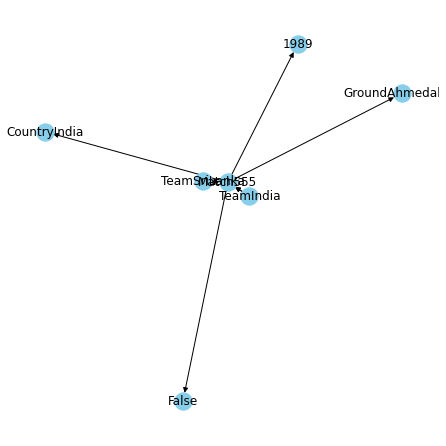

In [14]:
plt.figure(figsize=(6,6))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

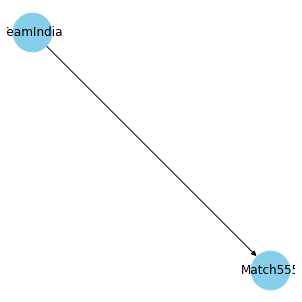

In [15]:
G=nx.from_pandas_edgelist(match555[match555['predicate']=="isHomeTeamIn"], "subject", "object",  
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(4,4))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

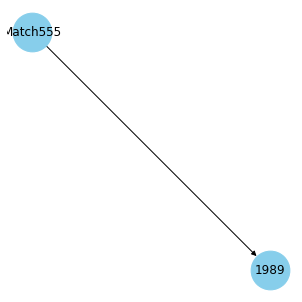

In [16]:
G=nx.from_pandas_edgelist(match555[match555['predicate']=="atYear"], "subject", "object",  
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(4,4))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

**1.2.4 Split the triples into train and validation set. Set the test size equal to 20% of the records in the dataset. Train the ComplexEx model for knowledge graphs embeddings and evaluate its performance using mr_score, mrr_score, hits_at_n_score. (0.75 points)**

In [22]:
from ampligraph.evaluation import train_test_split_no_unseen

test_size = int(len(triples) * 0.2)
X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=test_size)

In [23]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (37703, 3)
Test set size:  (9425, 3)


In [24]:
# Credits to Kyrylo in BDA2020 Slack group channel `HW6`
# !pip install tensorflow==1.13.2
# !pip install ampligraph

In [25]:
from ampligraph.latent_features import ComplEx
import tensorflow as tf

model = ComplEx(batches_count=50,
                epochs=300,
                k=100,
                eta=20,
                optimizer='adam', 
                optimizer_params={'lr':1e-4},
                loss='multiclass_nll',
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                seed=0, 
                verbose=True)

In [26]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(X_train)

Average Loss:   0.569054: 100%|██████████| 300/300 [48:25<00:00,  9.69s/epoch]


In [27]:
filter_triples = np.concatenate((X_train, X_valid))

In [28]:
from ampligraph.evaluation import evaluate_performance

ranks = evaluate_performance(X_valid,
                             model=model, 
                             filter_triples=filter_triples,
                             use_default_protocol=True,
                             verbose=True)

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 9425/9425 [04:38<00:00, 33.84it/s]


In [29]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.33
MR: 633.47
Hits@10: 0.45
Hits@3: 0.35
Hits@1: 0.26


**1.2.5 Create a dictionary with the embeddings of all teams and use PCA to project embeddings to 2D space. Cluster the team embeddings in 6 clusters and plot them in a 2D graph. (0.75 points)**

In [30]:
%%capture
# !pip install seaborn adjustText
# !git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
# !pip install incf.countryutils/.

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from incf.countryutils import transformations
%matplotlib inline

In [31]:
id_to_name_map = {**dict(zip(df.home_team_id, df.home_team)), **dict(zip(df.away_team_id, df.away_team))}

In [32]:
teams = pd.concat((df.home_team_id[df["train"]], df.away_team_id[df["train"]])).unique()
team_embeddings = dict(zip(teams, model.get_embeddings(teams)))

In [33]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in team_embeddings.values()]))

In [34]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

clustering_algorithm = KMeans(n_clusters=6, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(teams, model, clustering_algorithm, mode='entity')

In [35]:
def cn_to_ctn(country):
    try:
        return transformations.cn_to_ctn(id_to_name_map[country])
    except KeyError:
        return "unk"

In [36]:
plot_df = pd.DataFrame({"teams": teams, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1],
                        "continent": pd.Series(teams).apply(cn_to_ctn),
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

In [37]:
## change the top20 team //TODO
top20teams = ["TeamBelgium", "TeamFrance", "TeamBrazil", "TeamEngland", "TeamPortugal", "TeamCroatia", "TeamSpain", 
              "TeamUruguay", "TeamSwitzerland", "TeamDenmark", "TeamArgentina", "TeamGermany", "TeamColombia",
              "TeamItaly", "TeamNetherlands", "TeamChile", "TeamSweden", "TeamMexico", "TeamPoland", "TeamIran"]

def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df[plot_df.continent!="unk"], x="embedding1", y="embedding2", hue=hue)
    texts = []
    for i, point in plot_df.iterrows():
        if point["teams"] in top20teams or np.random.random() < 0.1:
            texts.append(plt.text(point['embedding1']+0.02, point['embedding2']+0.01, str(point["teams"])))
    adjust_text(texts)

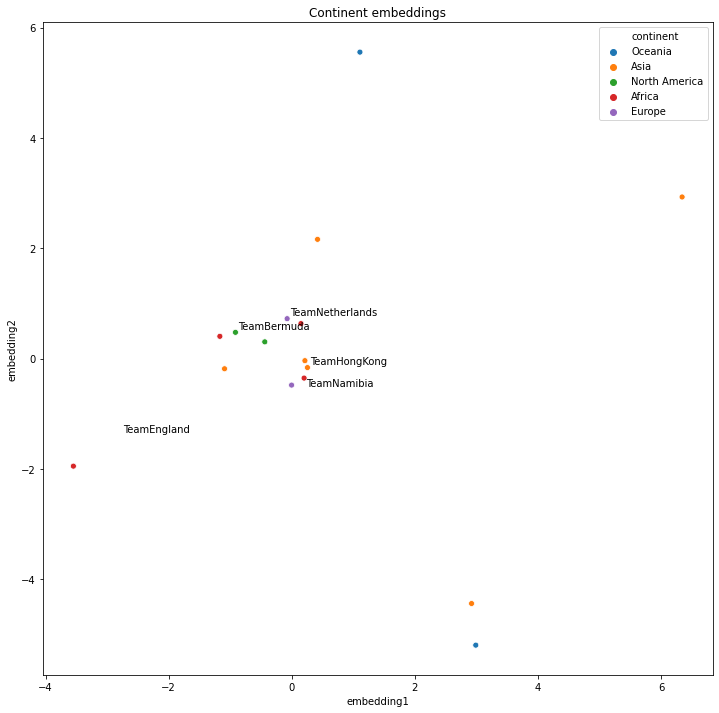

In [38]:
plot_clusters("continent")

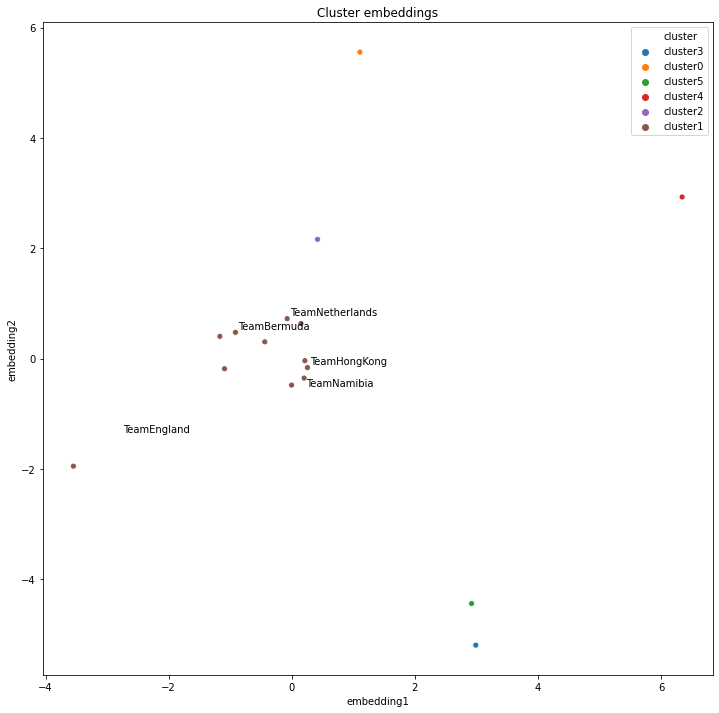

In [39]:
plot_clusters("cluster")

**1.2.6 In order to predict if the home team is going to win or lose we need to define a target variable. Create a new column called "result" in the dataframe that takes the value 'home_team_wins' if the home team is the winner and 'home_team_loses' if the home team has not won the match. (0.25 points)**

In [40]:
# Reference: https://stackoverflow.com/questions/21702342/creating-a-new-column-based-on-if-elif-else-condition
def helper(row):
    if row['home_team'] == row['winner']:
        val = "home_team_wins"
    else:
        val = "home_team_loses"
    return val

In [41]:
df['results'] = df.apply(helper, axis=1)

In [42]:
df.results.value_counts(normalize=True)

home_team_wins     0.556898
home_team_loses    0.443102
Name: results, dtype: float64

**1.2.7 Create a function that extracts the features (knowledge embeddings for home and away teams) and the target for a particular subset of the dataset (You can use the function from practice session). Run the function to get the variables for X_train, y_train, X_test and y_test. Remember that the train set indices are the same as in 1.2.2 (0.5 points)**


In [43]:
def get_features_target(mask):
    
    def get_embeddings(team):
        return team_embeddings.get(team, np.full(200, np.nan))
    
    X = np.hstack((np.vstack(df[mask].home_team_id.apply(get_embeddings).values),
                   np.vstack(df[mask].away_team_id.apply(get_embeddings).values)))
    y = df[mask].results.values
    return X, y

In [44]:
clf_X_train, y_train = get_features_target((df["train"]))
clf_X_test, y_test = get_features_target((~df["train"]))

In [55]:
# clf_X_train
# clf_X_test
# y_train
# y_test

In [45]:
clf_X_train.shape, clf_X_test.shape

((5891, 400), (1473, 400))

In [46]:
np.isnan(clf_X_test).sum()/clf_X_test.shape[1]

0.0

**1.2.8 Create an instance of XGBClassifier and fit the training samples. Evaluate the accuracy of the model in test set. (0.5 points)**

In [47]:
#%%capture
#!pip install xgboost
from xgboost import XGBClassifier

In [ ]:
# clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")

# Reference: https://stackoverflow.com/questions/48414481/xgboost-error-label-must-be-in-0-num-class-num-class-2
# change objective parameter from "multi:softmax" to "binary:logistic" because there are only 2 classes
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="binary:logistic")

In [63]:
clf_model.fit(clf_X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [64]:
df[~df["train"]].results.value_counts(normalize=True)

home_team_wins     0.547183
home_team_loses    0.452817
Name: results, dtype: float64

In [66]:
from sklearn import metrics
metrics.accuracy_score(y_test, clf_model.predict(clf_X_test))

0.6524100475220638

As baseline for this classification problem was **54.7%**, using only the knowledge embedding, we can build a classifier with higher accuracy which is **65.2%**.

# 2. Fairness & Interpretability ( 5 points)

In this section you are going to use the standard German Credit dataset used to bechmark many model interpretability techniques. The daset contains 1000 records of loan applications associatid with a risk score: Good or Bad.

**2.1 Load the dataset german_credit_data.csv. The dataset has some empty values. Choose one imputation method for each columnd and fill in the empty cells. (0.5 points)**

In [13]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import model_evaluation_utils as meu
import matplotlib.pyplot as plt
from collections import Counter
import shap
import eli5

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

Using TensorFlow backend.


In [14]:
gcd = pd.read_csv("german_credit_data.csv")
gcd.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [15]:
gcd.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [16]:
## Reference
## https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
## Impute use mean values for numeric columns and 
## the most frequent value for non-numeric columns (including categorical column)

from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [17]:
gcd = DataFrameImputer().fit_transform(gcd)
gcd.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,little,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,little,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [18]:
gcd.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

**2.2 Plot the values of the column Age against the Risk column. Do you think there exist  bias in this dataset ? (0.5 points)**

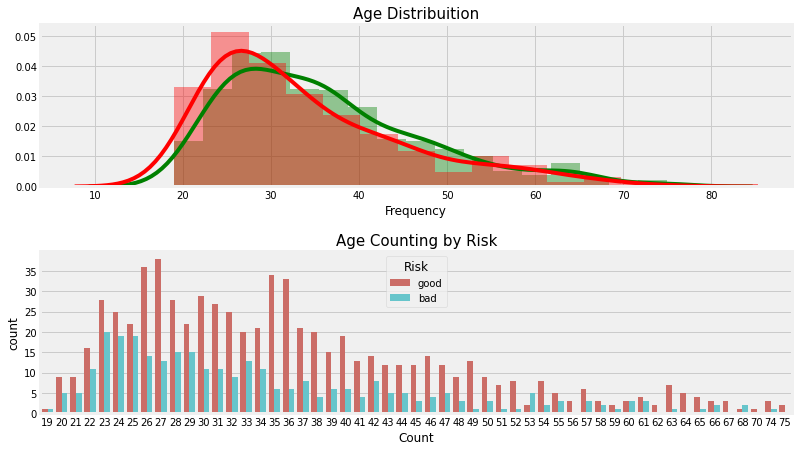

In [19]:
#Reference
# https://www.kaggle.com/kabure/predicting-credit-risk-model-pipeline

import matplotlib.pyplot as plt
import seaborn as sns

df_good = gcd[gcd["Risk"] == 'good']
df_bad = gcd[gcd["Risk"] == 'bad']

fig, ax = plt.subplots(nrows=2, figsize=(12,8))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

g1 = sns.distplot(df_good["Age"], ax=ax[0], 
             color="g")
g1 = sns.distplot(df_bad["Age"], ax=ax[0], 
             color='r')
g1.set_title("Age Distribuition", fontsize=15)
g1.set_xlabel("Age")
g1.set_xlabel("Frequency")

g2 = sns.countplot(x="Age",data=gcd, 
              palette="hls", ax=ax[1], 
              hue = "Risk")
g2.set_title("Age Counting by Risk", fontsize=15)
g2.set_xlabel("Age")
g2.set_xlabel("Count")
plt.show()

In [20]:
# it's a library that we work with plotly
import plotly.offline as py 
py.init_notebook_mode(connected=True) # this code, allow us to work with offline plotly version
import plotly.graph_objs as go # it's like "plt" of matplot
# import plotly.tools as tls # It's useful to we get some tools of plotly --> deprecated
import plotly.subplots as psp # Recommended one to replace plotly.tools
import warnings # This library will be used to ignore some warnings
from collections import Counter # To do counter of some features

df_good = gcd.loc[gcd["Risk"] == 'good']['Age'].values.tolist()
df_bad = gcd.loc[gcd["Risk"] == 'bad']['Age'].values.tolist()
df_age = gcd['Age'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)

#Creating the grid
fig = psp.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

<font color='red'> **Answer:** </font>

Yes, there is a bias, this dataset includes has more `Risk = good` compare to `Risk = bad` for almost every group of age.

**2.3 Calculate the percentage of the applications by gender Female that got a Bad credit score and a Good credit score. Do the same for Male gender. Do you believe there is enough data to think there is a bias in the dataset ? (0.5 points)**

In [21]:
# Good Risk
trace0 = go.Bar(
    x = gcd[gcd["Risk"]== 'good']["Sex"].value_counts().index.values,
    y = gcd[gcd["Risk"]== 'good']["Sex"].value_counts().values,
    text = np.round(gcd[gcd["Risk"]== 'good']["Sex"].value_counts().values / 
                    (gcd[gcd["Risk"]== 'good']["Sex"].value_counts().values + 
                     gcd[gcd["Risk"]== 'bad']["Sex"].value_counts().values), 2),
    textposition='auto',
    name='Good credit'
)

# Bad Risk
trace1 = go.Bar(
    x = gcd[gcd["Risk"]== 'bad']["Sex"].value_counts().index.values,
    y = gcd[gcd["Risk"]== 'bad']["Sex"].value_counts().values,
    text = np.round(gcd[gcd["Risk"]== 'bad']["Sex"].value_counts().values / 
                    (gcd[gcd["Risk"]== 'good']["Sex"].value_counts().values + 
                     gcd[gcd["Risk"]== 'bad']["Sex"].value_counts().values), 2),
    textposition = "auto",
    name="Bad Credit"
)

fig = psp.make_subplots(rows=1, cols=1)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)

fig['layout'].update(height=400, width=800, title='Credit Risk Distribution by Gender', boxmode='group')
py.iplot(fig, filename='gender-subplot')


In [22]:
gcd.Sex.value_counts()

male      690
female    310
Name: Sex, dtype: int64

<font color='red'> **Answer:** </font>

Yes, the amount of male gender is more than 2x size of the amount of female gender 

**2.4 Copy the data in a new dataframe and perform label encoding. Split the dataset in 80% train and 70% test set while keeping the random state equal to 99. Train the XGBoost classifier below and predict the results in test set. Report the accuracy and F1-score. Plot the classifcation report as well. (0.5 points)**

In [23]:
import xgboost as xgb
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=99)

In [24]:
gcd_xgb = gcd.copy()
gcd.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,little,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,little,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [25]:
# Change object to categorical data type https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html
cat_cols = gcd_xgb.select_dtypes(['object']).columns
gcd_xgb[cat_cols] = gcd_xgb[cat_cols].astype('category')
gcd_xgb[cat_cols] = gcd_xgb[cat_cols].apply(lambda x: x.cat.codes)
gcd_xgb.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,0,0,1169,6,5,1
1,22,0,2,1,0,1,5951,48,5,0
2,49,1,1,1,0,0,2096,12,3,1
3,45,1,2,0,0,0,7882,42,4,1
4,53,1,2,0,0,0,4870,24,1,0


In [26]:
# encoded data set
from sklearn.model_selection import train_test_split

X = gcd_xgb.loc[:, gcd_xgb.columns != 'Risk'] #Reference https://stackoverflow.com/questions/29763620/how-to-select-all-columns-except-one-column-in-pandas
y = gcd_xgb['Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 9), (200, 9), (800,), (200,))

In [27]:
y_test

890    1
983    0
107    1
609    1
113    0
      ..
780    0
561    0
544    1
846    0
669    1
Name: Risk, Length: 200, dtype: int8

In [28]:
xgc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=99, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [29]:
predictions = xgc.predict(X_test)
predictions[:10]

array([1, 0, 1, 0, 1, 0, 1, 1, 1, 1], dtype=int8)

In [30]:
class_labels = [0, 1]
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=predictions, classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.665
Precision: 0.6396
Recall: 0.665
F1 Score: 0.6475

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.43      0.31      0.36        61
           1       0.73      0.82      0.77       139

    accuracy                           0.67       200
   macro avg       0.58      0.57      0.57       200
weighted avg       0.64      0.67      0.65       200



**2.5 Plot 3 types of  feature importance given by XGBoost and interpret the results. (0.5 points)**

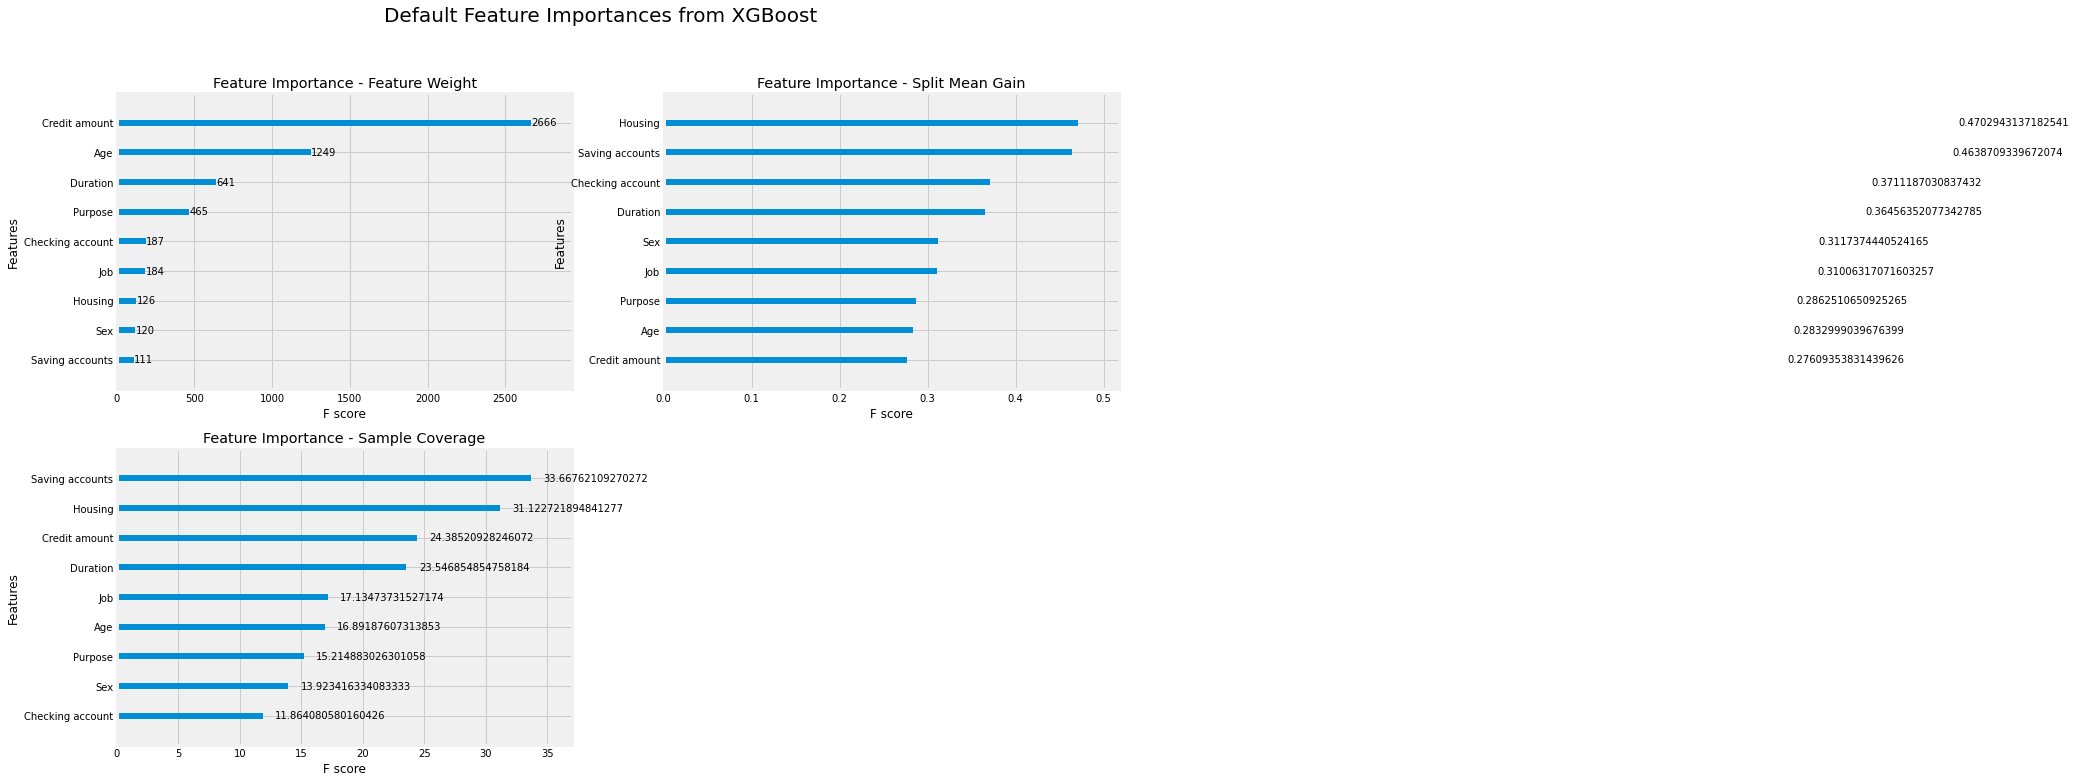

In [31]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=20)

ax1 = fig.add_subplot(2,2,1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2,2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2,3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")

<font color='red'> **Answer:** </font>

- For the weight method (the default feature importance method in XGBoost), `Credit amount` is the most frequent features that appears in our prediction model.
- For the gain method, `Housing` dominates all the others.  
- For the cover method, `Saving accounts` feature is most predictive of the `Risk`

**2.6 Use eli5 to analyze the most important features of a sample where the credit score is equal to Bad and another sample when the credit score is equal to Good. Explain briefly the results (0.5 points)**

In [32]:
eli5.show_weights(xgc.get_booster())

Weight,Feature
0.1499,Housing
0.1479,Saving accounts
0.1183,Checking account
0.1162,Duration
0.0994,Sex
0.0988,Job
0.0912,Purpose
0.0903,Age
0.0880,Credit amount


In [33]:
# convert pandas dataframe to array
y_test_array = y_test.to_numpy()

In [34]:
# Credit Score = Bad (Actual and Predicted Label = 0)
doc_num = 1
print('Actual Label:', y_test_array[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=list(X.columns) ,show_feature_values=True)

Actual Label: 0
Predicted Label: 0


In [35]:
# Credit Score = Good (Actual and Predicted Label = 1)
doc_num = 0
print('Actual Label:', y_test_array[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=list(X.columns) ,show_feature_values=True)

Actual Label: 1
Predicted Label: 1


<font color='red'> **Answer:** </font>

- To predict __`Bad credit score`__, the most influential features being the __`Age`, `Credit Amount`, and `Duration`__
- To predict __`Good credit score`__, the most influential features being the __`Job`, `Credit Amount`, `Housing`, and `Sex`__


**2.7 Use SHAP to explain the prediction of the model for a sample where the credit score is equal to Bad and another sample when the credit score is equal to Good. Explain briefly the results.(0.5 points)**

In [36]:
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(X_test)

In [37]:
pd.DataFrame(shap_values).head()

,0,1,2,3,4,5,6,7,8
0,-0.150276,0.325049,0.455878,0.363644,-0.251660,-0.042343,0.599352,-1.136219,-0.903826
1,-0.437233,0.205245,0.462746,0.158127,-0.083947,-0.012808,-1.247740,-1.278533,-0.172150
2,0.448052,0.388699,0.520650,0.179644,0.048139,0.324531,1.654544,-1.058081,0.221556
3,-0.695268,0.231505,-0.225976,-1.474535,-0.154879,0.347443,0.028478,0.830117,-1.013851
4,-0.491310,-0.358411,0.696099,0.137972,-0.082904,-0.013881,0.292717,-0.935039,-0.135334


In [38]:
print('Expected Value:', explainer.expected_value)

Expected Value: 0.9958508


In [39]:
# Credit Score = Bad
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [40]:
# Credit Score = Good 
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

<font color='red'> **Answer:** </font>

- The `**color red**` means the feature which pushing the prediction higher, and the `**color blue**` is the features which pushing the prediction lower.
- For `Bad credit score`, the features that give most influences are __`Duration = 36`, `Credit amount = 8,229`, `Age = 26`, and `Purpose = 1 (buy a Car)`__
- For `Good credit score`, the features which give most influences are __`Sex = 1 (Male)`, `Housing = 1 (Own)`, `Job = 3`, and `Credit amount = 2,442`__


**2.8 Use SHAP to explain the prediction of the model for  the first 250 samples. Based on the similar patterns explain briefly the results(0.75 points)**

In [41]:
shap.force_plot(explainer.expected_value, shap_values[:250,:], X_test.iloc[:250,:])

<font color='red'> **Answer:** </font>

The above visualization can be interacted with in multiple ways. The default visualization shows some interesting model prediction pattern decisions.

- The first 85 test samples all probably __have good credit risk score__ and they __dominated by Male__ or\and have __age 30+__ or\and have a __purpose = 5 (Radio/TV)__
- From test samples 100 to 106 all probably __have bad credit risk score__ and they have __high value of credit amount (~4000++)__ or\and have __duration 36+ months__
- From test samples 170++ all probably __have bad credit risk score__

**2.9 Plot as a bar chart the feature importances received from SHAP. Finally compare these results  with the result from 2.5 and 2.8. (0.75 points)**

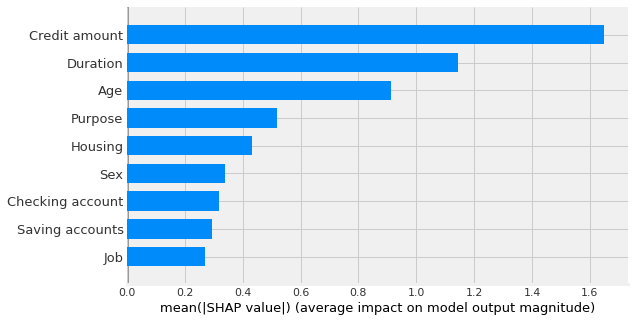

In [42]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

<font color='red'> **Answer:** </font>

Comparison task 2.9 with task 2.5 and task 2.8:
- Compare to task 2.8 result, these result is very similar to each others. 
- Compare to task 2.5 result, these result have similar result to XGBoost __weight__ feature importance, but have a big difference with __gain and cover__ feature importances as that two feature stated that __housing and saving accounts__ as the most important features, but both of them have low score in task 2.9 result


## How long did it take you to solve the homework?

* Please answer as precisely as you can. It does not affect your points or grade in any way. It is okay, if it took 0.5 hours or 24 hours. The collected information will be used to improve future homeworks.

<font color='red'> **Answer:**</font>

**<font color='red'>(please change X in the next cell into your estimate)</font>**

8 hours

## What is the level of difficulty for this homework?
you can put only number between $0:10$ ($0:$ easy, $10:$ difficult)

<font color='red'> **Answer:**</font>
6